### Torus Geometry
- **Triangular unit cell**: Primitive vectors |G₁|=|G₂| with 120 degree in between
- **Landau level**: n = 0 (lowest Landau level)
- **Brillouin zone area**: 2π/l² = √0.75 × G²
- **Magnetic length**: l = √(ℏ/eB) sets the length scale

### Bilayer Parameters
- **Nc_conserved = 2**: Number of layers (components)
- **Inter-layer distance**: d/l
- **Tunneling amplitude**: t/W0 = 0.0
- **Displacement field**: ΔE/W0, energy difference between layers

### Interaction Details
- **Layer conservation**: Interactions preserve layer index of each particle
- **Layer symmetric**: Interactions unchanged if swap the two layer indices
- **Gate Screening**: D/l
- **Different-layer interaction**: Includes e^{-ql*d/l} attenuation factor
- **Form factor**: See arXiv.2509.07784 Eq.(A28) 

In [ ]:
# These packages are not included in the MomentumED package. 
# Use the following line to add them:
# using Pkg; Pkg.add("CairoMakie"); Pkg.add("QuadGK"); Pkg.add("ClassicalOrthogonalPolynomials")

# Import the momentum-conserved exact diagonalization package
using MomentumED, LinearAlgebra
include("../Landau level torus.jl")
using .LLT

# square/triangular lattice
sqa_lattice = ReciprocalLattice(:square);          # == ReciprocalLattice(1.0im)
tri_lattice = ReciprocalLattice(:triangular);      # == ReciprocalLattice(cispi(2//3))

using CairoMakie # for plotting
CairoMakie.activate!()

# Plot the energy spectrum
function plot_ed_spectrum(;title=nothing, ylims = (nothing, nothing))
    fig = Figure();
    ax = Axis(fig[1, 1];
        xlabel = "$(Gk[2])k1+k2",
        ylabel = "Energy per unit cell (W₀ = e²/ϵl)"
    )
    ax_top = Axis(fig[1, 1];
        xaxisposition = :top
    )
    top_ticks = ([], [])
    hidespines!(ax_top)
    hidexdecorations!(ax_top; label = false, ticklabels = false)
    hideydecorations!(ax_top)
    linkxaxes!(ax, ax_top)

    # Plot energy levels for each momentum block
    for i in 1:length(subspaces)
        x = Gk[2] * ss_k1[i] + ss_k2[i]
        push!(top_ticks[1], x)
        push!(top_ticks[2], string(i))
        for e in energies[i]
            scatter!(ax, x, e/Nk/LLT.W0, color = :blue, marker=:hline)
        end
    end
    ylims!(ax, ylims...)
    ax_top.xticks = top_ticks
    if title isa String
        ax_top.subtitle = title
    end
    display(fig)
end

function plot_entanglement_spectrum(;title=nothing, ylims = (nothing, nothing))
    fig = Figure();
    ax = Axis(fig[1,1];
        xlabel = "Ne in A-part",
        xticksvisible = false,
        xgridvisible = false,
        xminorgridvisible = true,
    )

    x = 0
    NA_lines = Float64[-0.5;]
    xtickposition = Float64[];
    xticklabel = String[];
    for indexNA in CartesianIndices(entanglement_spectrum)
        x_begin = x
        for (indexkA, spectrum) in enumerate(entanglement_spectrum[indexNA])
            if !isempty(spectrum)
                for e in spectrum
                    scatter!(ax, x, e, color = :blue, marker=:hline)
                end
                x += 1
            end
        end
        x_end = x
        if x_end > x_begin
            NA = string(indexNA[1]-1)
            for i in 2:length(indexNA)
                NA *= ",$(indexNA[i]-1)"
            end
            push!(xtickposition, 0.5(x_begin+x_end-1))
            push!(xticklabel, NA)
            push!(NA_lines, x+0.5)
        end
    end
    ax.xticks = (xtickposition, xticklabel)
    ax.xminorticks = NA_lines
    if title isa String
        ax.subtitle = title
    end
    ylims!(ax, ylims...)
    display(fig)
end

plot_ed_spectrum (generic function with 2 methods)

In [2]:
# Define k-mesh for bilayer system (4×3 mesh, Nk=12) in triangular lattice
k_list = [0 1 2 3 0 1 2 3 0 1 2 3;
          0 0 0 0 1 1 1 1 2 2 2 2]
Nk = 12
Gk = (4, 3)  # Grid dimensions


# number of electrons in each layer
Ne1 = 3
Ne2 = 3

# Number of layers (components) for bilayer system
Nc_conserve = 2

2

In [ ]:
# Define k-mesh for bilayer system (4×4 mesh, Nk=16) in triangular lattice

#=
k_list = [0 1 2 3 0 1 2 3 0 1 2 3 0 1 2 3;
          0 0 0 0 1 1 1 1 2 2 2 2 3 3 3 3]
Nk = 16
Gk = (4, 4)  # Grid dimensions

# number of electrons in each layer
Ne1 = 4
Ne2 = 4

# Number of layers (components) for bilayer system
Nc_conserve = 2
=#

2

In [4]:
# Define k-mesh for bilayer system (4×5 mesh, Nk=20) in triangular lattice
# Note: 32GB memory is insufficient with :spare method
# Use method = :map

#=

k_list = [0 1 2 3 0 1 2 3 0 1 2 3 0 1 2 3 0 1 2 3;
          0 0 0 0 1 1 1 1 2 2 2 2 3 3 3 3 4 4 4 4]
Nk = 20
Gk = (4, 5)  # Grid dimensions

# number of electrons in each layer
Ne1 = 5
Ne2 = 5

# Number of layers (components) for bilayer system
Nc_conserve = 2

=#

In [ ]:
ΔE = 0 * LLT.W0                # Energy difference between the two layers

# Set up one-body Hamiltonian matrix for inter-layer tunneling
# H_onebody[c1, c2, cc, k] : no hopping from component c2 to c1
# For bilayer system: Nc_hopping=1, Nc_conserve=2, Nk=6
H_onebody_bilayer_no_tunneling = zeros(ComplexF64, 1, 1, Nc_conserve, Nk)
# Add energy difference terms: ΔE = 0.5 * W0 between different layers
# No tunneling
for k_idx in 1:Nk
    H_onebody_bilayer_no_tunneling[1, 1, 1, k_idx] = 0.5ΔE
    H_onebody_bilayer_no_tunneling[1, 1, 2, k_idx] = -0.5ΔE
end

# Set up component parameters: (layer, level, Chern number, pseudospin)
sys_int = LandauInteraction(tri_lattice,
    (1, 1, 1, 0),
    (2, 1, 1, 0)
);

In [60]:
# Interaction parameters

# Coulomb
sys_int.D_l = 10.0                  # Screening length D/l
sys_int.d_l = 0.2                   # Inter-layer distance d/l
# compute the pseudo-potential components
intra_PP = LLT.pseudo_potential_decomposition.(0:15; same_layer = true,  D_l = sys_int.D_l, d_l = sys_int.d_l)
inter_PP = LLT.pseudo_potential_decomposition.(0:15; same_layer = false, D_l = sys_int.D_l, d_l = sys_int.d_l)
@show intra_PP
@show inter_PP

# Haldane pseudo-potential
sys_int.V_intra = [0.0; 0.8; 0.0; 0.0]          # Intralayer Haldane pseudo-potential in unit of W0
sys_int.V_inter = [1.5; 0.0; 0.0; 0.0]          # Interlayer Haldane pseudo-potential in unit of W0

# or use Coulomb interaction with a cutoff in m
# sys_int.V_intra = copy(intra_PP)
# sys_int.V_inter = copy(inter_PP)

# choose a linear mixing between Haldane and Coulomb interaction
sys_int.mix = 1                  # mix * Haldane + (1-mix) * Coulomb

# Create parameter structure for bilayer system
para_conserve = EDPara(
    k_list = k_list, 
    Gk = Gk, 
    Nc_hopping = 1,
    Nc_conserve = Nc_conserve,
    H_onebody = H_onebody_bilayer_no_tunneling,
    V_int = sys_int,
    FF_inf_angle = LLT.Landau_ff_inf(sys_int),
);

intra_PP = [1.634691278690283, 0.7493383601164756, 0.5286420776719373, 0.4187109289395484, 0.35030875074472057, 0.30266490471845026, 0.2671251264726862, 0.23936242215567627, 0.21694297387769915, 0.19837954758714904, 0.18270552679386037, 0.16926192958445965, 0.15758204297210426, 0.14732486590665303, 0.13823469977565214, 0.13011555581165724]
inter_PP = [1.4511894967074435, 0.7417093243133075, 0.5264772245136036, 0.41763036741493487, 0.3496396906862018, 0.30220201813137615, 0.26678248436536856, 0.23909698282384967, 0.21673050598765223, 0.19820523802144346, 0.18255974688684778, 0.16913811591600048, 0.15747554859673946, 0.14723229723864525, 0.13815351381895055, 0.13004380499306584]


In [61]:
# Create momentum blocks (Hilbert subspace) for bilayer system
subspaces, ss_k1, ss_k2 = 
    ED_momentum_subspaces(para_conserve, (Ne1, Ne2));
display(length.(subspaces))

# one-body and two-body terms in Hamiltonian
scat1 = ED_sortedScatterList_onebody(para_conserve);
scat2 = ED_sortedScatterList_twobody(para_conserve);

# construct the Hamiltonian operator
hmlt = MBOperator(scat2, scat1; upper_hermitian = true)

12-element Vector{Int64}:
 4036
 4032
 4032
 4036
 4032
 4032
 4036
 4032
 4032
 4036
 4032
 4032

Many Body Operator (upper_hermitian=true) :
	Vector{MomentumEDCore.Scatter{2}} with 1368 scattering terms


In [ ]:
Neigen = 10  # Number of eigenvalues to compute per block
energies = Vector{Vector{Float64}}(undef, length(subspaces));
vectors = Vector{Vector{<:MBS64Vector}}(undef, length(subspaces));
for i in eachindex(subspaces)
    println("Processing subspace #$i with size $(length(subspaces[i])), momentum $(ss_k1[i]), $(ss_k2[i])")
    energies[i], vectors[i] = EDsolve(subspaces[i], hmlt;
        N = Neigen, showtime = true, ishermitian = true,
        method = :sparse
    )
end

Processing block #1 with size 4036, momentum 0, 0
  0.163635 seconds (519 allocations: 46.874 MiB, 83.27% gc time)
  0.192413 seconds (9.56 k allocations: 63.214 MiB, 2.45% gc time)
Processing block #2 with size 4032, momentum 0, 1
  0.026933 seconds (559 allocations: 46.803 MiB, 11.52% gc time)
  0.146207 seconds (8.60 k allocations: 50.577 MiB, 4.11% gc time)
Processing block #3 with size 4032, momentum 0, 2
  0.027499 seconds (514 allocations: 46.799 MiB, 9.31% gc time)
  0.163385 seconds (8.18 k allocations: 48.576 MiB, 2.78% gc time)
Processing block #4 with size 4036, momentum 1, 0
  0.169906 seconds (558 allocations: 46.878 MiB, 84.91% gc time)
  0.175231 seconds (6.94 k allocations: 42.618 MiB, 1.78% gc time)
Processing block #5 with size 4032, momentum 1, 1
  0.028172 seconds (474 allocations: 45.524 MiB, 6.99% gc time)
  0.130965 seconds (6.89 k allocations: 40.838 MiB, 2.42% gc time)
Processing block #6 with size 4032, momentum 1, 2
  0.028641 seconds (514 allocations: 46.79

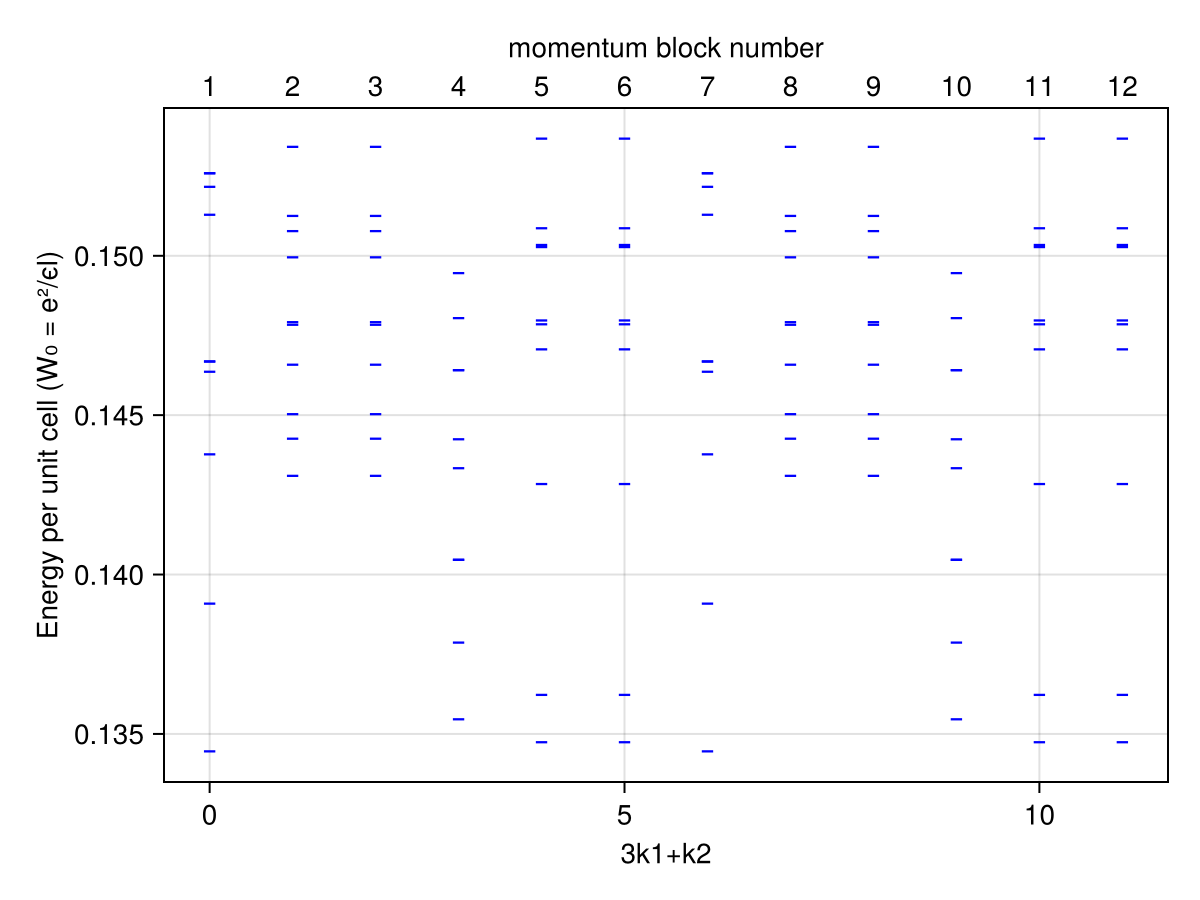

In [63]:
plot_ed_spectrum();

In [64]:
# check energies explicitly to see degeneracy.

sn = 1 # the subspace number to inspect
println("total momentum: ", ss_k1[sn], "  ", ss_k2[sn])
energies[sn]/Nk/LLT.W0

total momentum: 0  0


10-element Vector{Float64}:
 0.13445217066140458
 0.13908682063147032
 0.143770841005704
 0.14636198622824265
 0.14668389271533505
 0.14668389271533552
 0.15128706182429286
 0.15216354791789968
 0.15258986549464681
 0.15258986549464743

Compute and plot one-body reduced density matrix

eigvals(rdm) = [0.24766053350238978, 0.24766053350239015, 0.24766053350239037, 0.2476605335023905, 0.2476605335023906, 0.24766053350239062, 0.24766053350239142, 0.24766053350239153, 0.24766053350239162, 0.24766053350239164, 0.24766053350239167, 0.2476605335023925, 0.25233946649760586, 0.25233946649760647, 0.25233946649760725, 0.2523394664976073, 0.2523394664976083, 0.2523394664976087, 0.2523394664976105, 0.25233946649761124, 0.252339466497612, 0.25233946649761213, 0.2523394664976132, 0.25233946649761324]


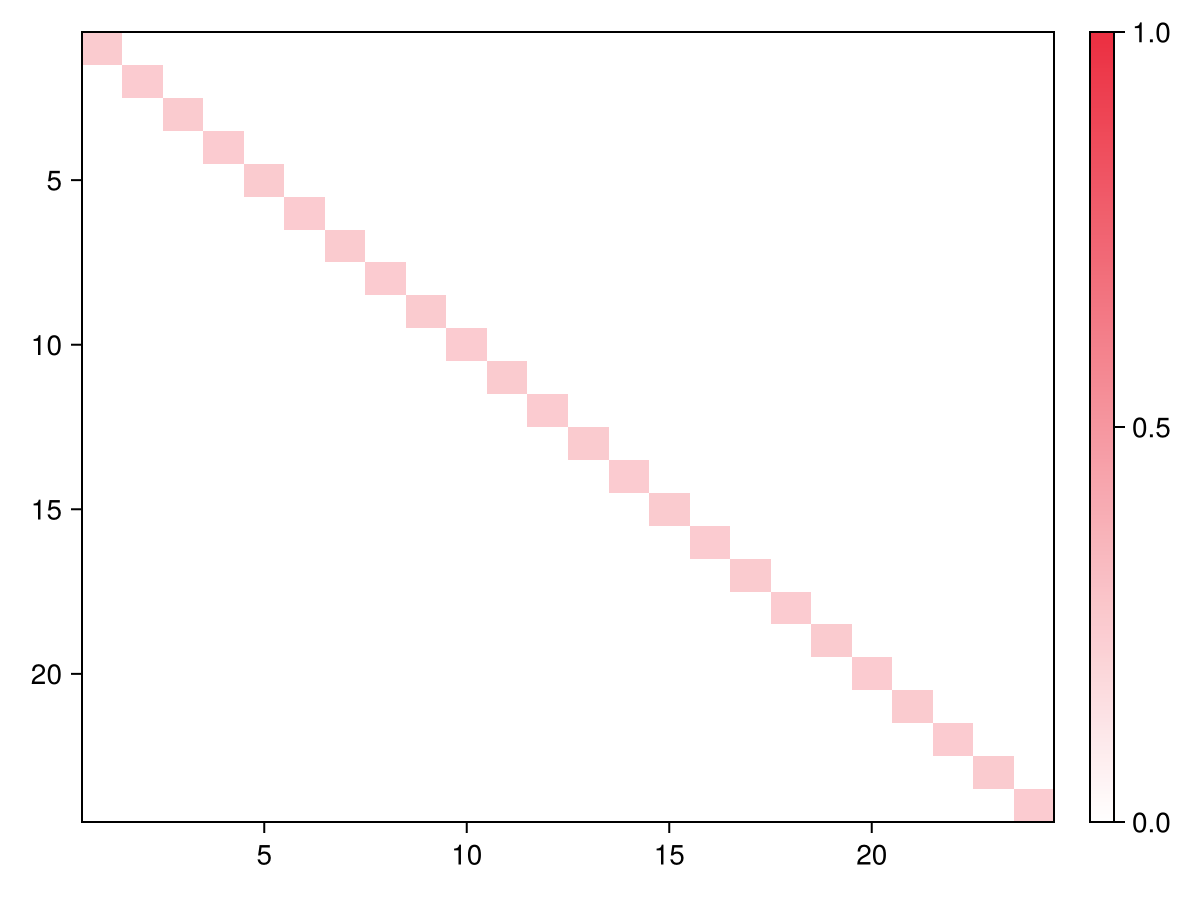

In [ ]:
# plot the reduced density matrix of the ground eigenstate in the first block
sn = 1
rdm = RDM_OneBody(vectors[sn][1])
@show eigvals(rdm)

fig = Figure();
ax = Axis(fig[1, 1]; yreversed = true)
hm = heatmap!(ax, abs.(rdm); colorrange = (0,1), 
    colormap = range(Makie.Colors.colorant"white", stop=Makie.Colors.colorant"#ec2f41", length=15)
)
Colorbar(fig[1, 2], hm)
fig

Compute the many-body connection and the Wilson loop for many-body Chern number.

In [32]:
# twist angle path for the Wilson loop integral
N_shift = 10  # number of shifts along each edge
path = Tuple{Float64, Float64}[(0.0, 0.0)]
push!(path, (1/N_shift, 0.0))
push!(path, (1/N_shift, 1/N_shift))
push!(path, (0.0, 1/N_shift))
push!(path, (0.0, 0.0))
path

5-element Vector{Tuple{Float64, Float64}}:
 (0.0, 0.0)
 (0.1, 0.0)
 (0.1, 0.1)
 (0.0, 0.1)
 (0.0, 0.0)

In [33]:
sn = 2                     # subspace number
nstates = 1                # number of degenerating states

psi_before = vectors[sn][1:nstates]
ED_connection_gaugefixing!(psi_before)  # fix global phase

WilsonLoopIntegral= Vector{Float64}(undef, 4)
for i in eachindex(WilsonLoopIntegral)

    println("path point #$i \t $(path[i+1])")

    # One-body terms do not change when k are shifted
    scat_list2 = ED_sortedScatterList_twobody(para_conserve; kshift = path[i+1]);
    psi_after = EDsolve(subspaces[sn], scat_list2, scat1; N = 6,
        showtime = false,
    )[2][1:nstates]
    ED_connection_gaugefixing!(psi_after)  # fix global phase

    WilsonLoopIntegral[i] = ED_connection_step( 
        psi_after, psi_before, path[i+1], path[i], para_conserve;
        wavefunction_tol = 1e-8, print_amp = true,
        amp_warn_tol = 0.7, amp_warn = true
    )

    psi_before .= psi_after
end
ManyBodyChernNumber = sum(WilsonLoopIntegral) / (2π) * N_shift^2


path point #1 	 (0.1, 0.0)
Inner product: amp = 0.9999999999999982, phase = -0.026179938779913786
path point #2 	 (0.1, 0.1)
Inner product: amp = 0.9999999999999962, phase = 0.120427718387611
path point #3 	 (0.0, 0.1)
Inner product: amp = 0.9999999999999974, phase = 0.041887902047864266
path point #4 	 (0.0, 0.0)
Inner product: amp = 0.9999999999999999, phase = -0.10471975511966192


0.5000000000000259

structure factor and exciton density

In [37]:
NG = 2
index_shift = NG .* Gk .+ 1
densities = MBOperator[density_operator(q1, q2, lf, li; 
        para = para_conserve, form_factor = true)
    for q1 in -NG*Gk[1]:NG*Gk[1], q2 in -NG*Gk[2]:NG*Gk[2], lf = 1:2, li=1:2
];
function structure_factor_expectation(myvec)
    structure_factor = similar(densities, ComplexF64)
    for q1 in -NG*Gk[1]:NG*Gk[1], q2 in -NG*Gk[2]:NG*Gk[2]
        for lf = 1:2, li = 1:2
            structure_factor[index_shift[1]+q1, index_shift[2]+q2, lf, li] = 
                ED_bracket_threaded(myvec, 
                    densities[index_shift[1]-q1, index_shift[2]-q2, li, lf], 
                    densities[index_shift[1]+q1, index_shift[2]+q2, lf, li], myvec
                )
            if mod(q1, Gk[1]) == 0 && mod(q2, Gk[2])== 0 && lf==li
                structure_factor[index_shift[1]+q1, index_shift[2]+q2, lf, li] -= 
                    ED_bracket_threaded(myvec, densities[index_shift[1]-q1, index_shift[2]-q2, li, lf], myvec) * 
                    ED_bracket_threaded(myvec, densities[index_shift[1]+q1, index_shift[2]+q2, lf, li], myvec)
            end
        end
    end
    structure_factor ./= Nk
end

structure_factor_expectation (generic function with 1 method)

In [40]:
@time str_fac2 = structure_factor_expectation(vectors[2][1]);
@show maximum(abs.(imag.(str_fac2)))
@show extrema(real.(str_fac2))
@show str_fac2[index_shift..., 1,2]
@show str_fac2[index_shift..., 2,1]

@time str_fac3 = structure_factor_expectation(vectors[3][1]);
@show maximum(abs.(imag.(str_fac3)))
@show extrema(real.(str_fac3))
@show str_fac3[index_shift..., 1,2]
@show str_fac3[index_shift..., 2,1]

  0.914751 seconds (65.16 k allocations: 4.465 MiB)
maximum(abs.(imag.(str_fac2))) = 1.3010426069826053e-18
extrema(real.(str_fac2)) = (-2.0724163126336257e-15, 0.22226087358022398)
str_fac2[index_shift..., 1, 2] = 3.9826359802634194e-17 + 0.0im
str_fac2[index_shift..., 2, 1] = 8.608565249534905e-17 + 0.0im
  0.922529 seconds (65.21 k allocations: 4.469 MiB, 1.26% gc time)
maximum(abs.(imag.(str_fac3))) = 1.3733227518149722e-18
extrema(real.(str_fac3)) = (2.4294440326876272e-20, 0.22226087358022317)
str_fac3[index_shift..., 1, 2] = 4.907821834117717e-17 + 0.0im
str_fac3[index_shift..., 2, 1] = 6.100444223851771e-17 + 0.0im


6.100444223851771e-17 + 0.0im

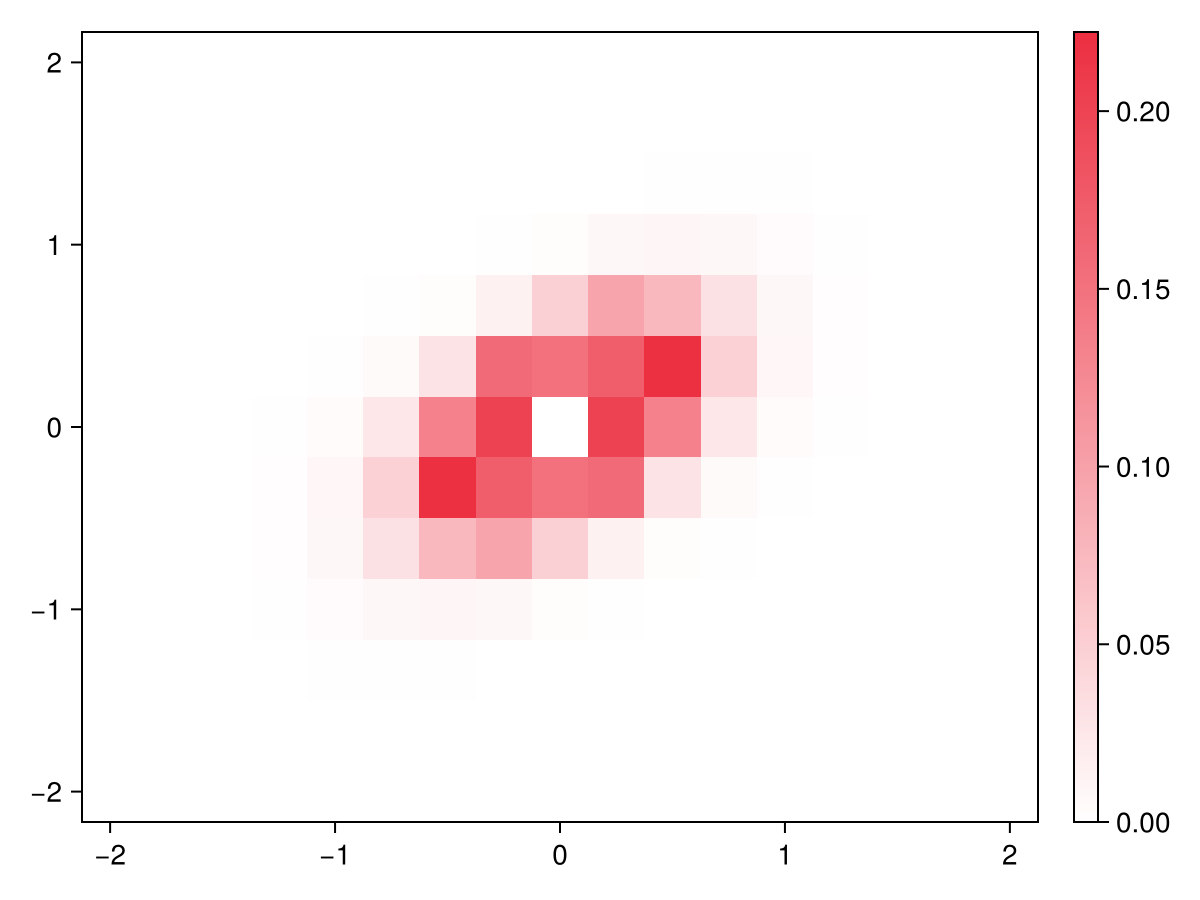

CairoMakie.Screen{IMAGE}


In [44]:
let structure_factor = str_fac2, layer = (2,1)
    fig = Figure();
    ax = Axis(fig[1,1])
    hm = heatmap!(ax, (-2Gk[1]:2Gk[1])./Gk[1], (-2Gk[2]:2Gk[2])./Gk[2], 
        real.(structure_factor[:,:,layer...]);
        colorrange = (0.0, maximum(real.(structure_factor[:,:,layer...]))),
        colormap = range(Makie.Colors.colorant"white", stop=Makie.Colors.colorant"#ec2f41", length=15)
    )
    Colorbar(fig[1, 2], hm)
    display(fig)
end

In [50]:
@time str_fac11 = structure_factor_expectation(vectors[1][1]);
@time str_fac12 = structure_factor_expectation(vectors[1][2]);

str_fac1 = str_fac11 + str_fac12

@show maximum(abs.(imag.(str_fac1)))
@show extrema(real.(str_fac1))
@show str_fac1[index_shift..., 1,2]
@show str_fac1[index_shift..., 2,1]

  0.919651 seconds (65.17 k allocations: 4.465 MiB)
  0.937824 seconds (65.22 k allocations: 4.468 MiB)
maximum(abs.(imag.(str_fac1))) = 3.469446951953614e-18
extrema(real.(str_fac1)) = (-1.9243865760169383e-15, 0.7054209412558385)
str_fac1[index_shift..., 1, 2] = 0.7054209412558385 + 3.469446951953614e-18im
str_fac1[index_shift..., 2, 1] = 0.7054209412558385 - 5.782411586589357e-19im


0.7054209412558385 - 5.782411586589357e-19im

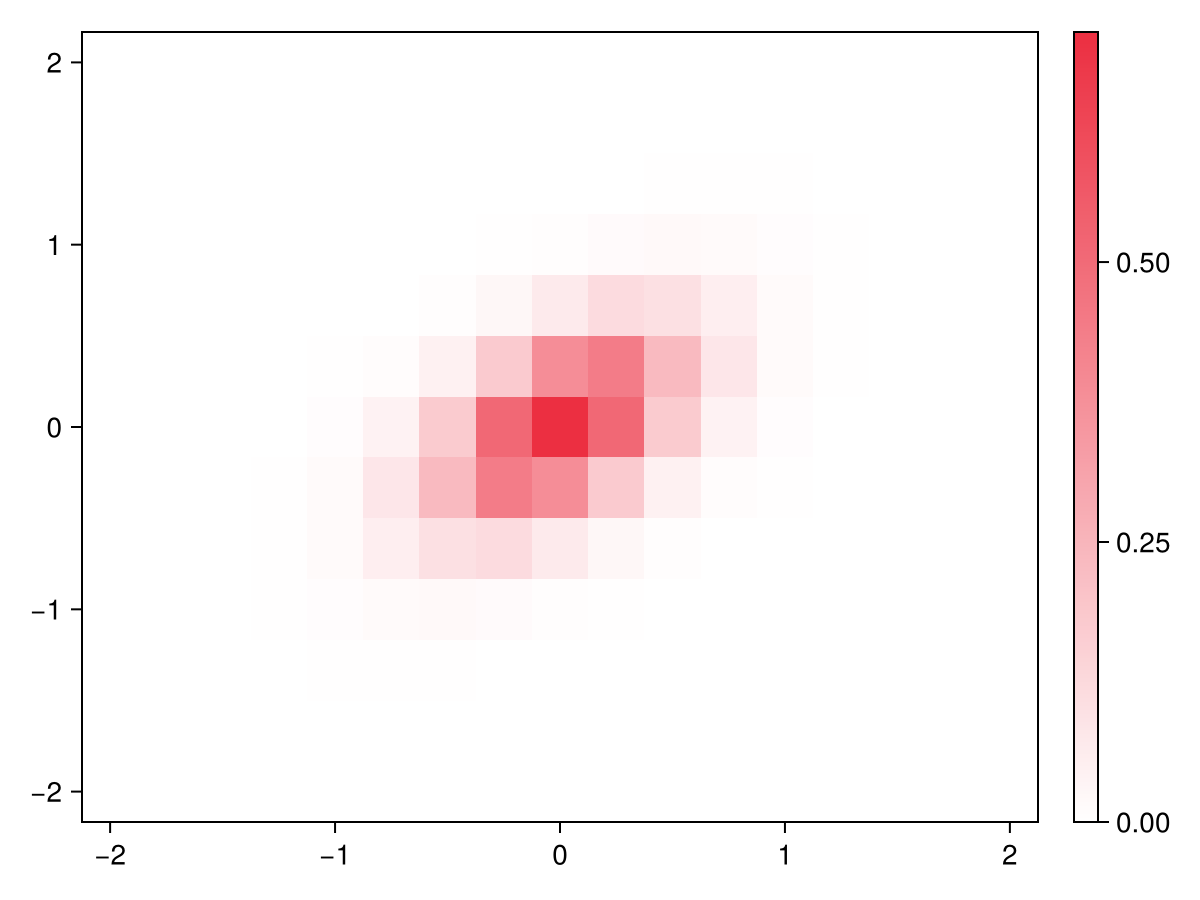

CairoMakie.Screen{IMAGE}


In [53]:
let structure_factor = str_fac1, layer = (1,2)
    fig = Figure();
    ax = Axis(fig[1,1])
    hm = heatmap!(ax, (-2Gk[1]:2Gk[1])./Gk[1], (-2Gk[2]:2Gk[2])./Gk[2], 
        real.(structure_factor[:,:,layer...]);
        colorrange = (0.0, maximum(real.(structure_factor[:,:,layer...]))),
        colormap = range(Makie.Colors.colorant"white", stop=Makie.Colors.colorant"#ec2f41", length=15)
    )
    Colorbar(fig[1, 2], hm)
    display(fig)
end